# ATIVIDADE 2 -- PROCESSAMENTO DIGITAL DE IMAGENS



### INTEGRANTES
|**Participantes**|**RA**|
|-|-|
|Bruno Matos de Souza|769754|
|Gustavo M. Barreto|790832|
|Lucas Maciel Balieiro|800534|


## SEGMENTAÇÃO DOS PRINCIPAIS TECIDOS


In [13]:
ATLAS_IMG_DIR     = "Atlas"
CLINICS_IMG_DIR   = "imagens-clinicas"

ATLAS_MNI_REF = f"{ATLAS_IMG_DIR}/mni_ref.nii.gz"
ATLAS_MNI_CSF = f"{ATLAS_IMG_DIR}/mni_csf.nii.gz"
ATLAS_MNI_GM  = f"{ATLAS_IMG_DIR}/mni_gm.nii.gz"
ATLAS_MNI_WM  = f"{ATLAS_IMG_DIR}/mni_wm.nii.gz"

CLINICS_IMG_T1 = f"{CLINICS_IMG_DIR}/IXI002-Guys-0828-T1.nii.gz"
CLINICS_IMG_T2 = f"{CLINICS_IMG_DIR}/IXI012-HH-1211-T1.nii.gz"
CLINICS_IMG_T3 = f"{CLINICS_IMG_DIR}/IXI013-HH-1212-T1.nii.gz"
CLINICS_IMG_T4 = f"{CLINICS_IMG_DIR}/IXI014-HH-1236-T1.nii.gz"
CLINICS_IMG_T5 = f"{CLINICS_IMG_DIR}/IXI015-HH-1258-T1.nii.gz"

AtlasPaths = {
    "REF": ATLAS_MNI_REF,
    "CSF": ATLAS_MNI_CSF,
    "GM" : ATLAS_MNI_GM,
    "WM" : ATLAS_MNI_WM
}

ClinicalImgPaths  = [
    CLINICS_IMG_T1,
    CLINICS_IMG_T2,
    CLINICS_IMG_T3,
    CLINICS_IMG_T4,
    CLINICS_IMG_T5
]



### MÉTODO K-MEANS
Para este método, usaremos funções já implementadas do pacote `sckit-learn`.

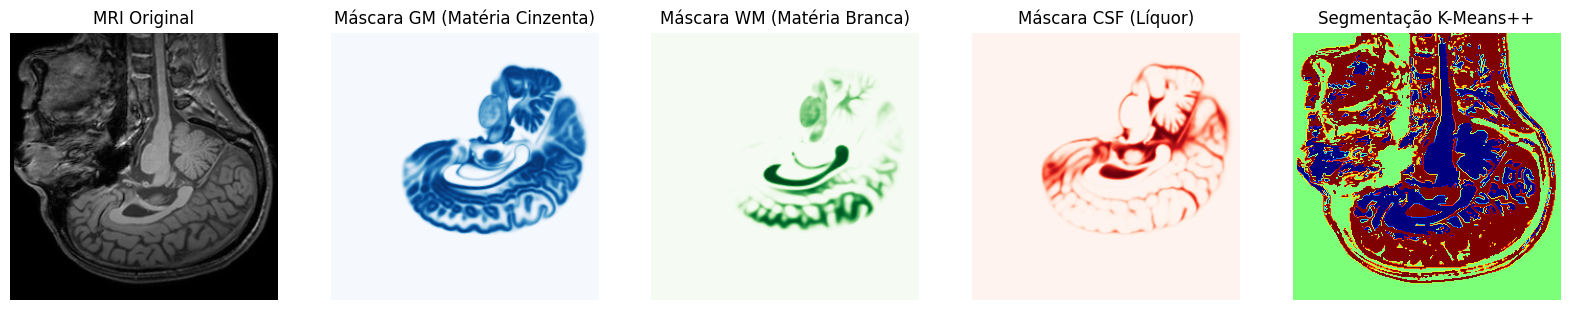

In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def reorient_image(image, reference):
    return sitk.Resample(image, reference, sitk.Transform(), sitk.sitkLinear, 0.0, image.GetPixelID())

def align_mask(mask, reference_mri):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_mri)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Mantém os valores discretos da máscara
    resampler.SetTransform(sitk.Transform())             # Usa a identidade para alinhamento
    aligned_mask = resampler.Execute(mask)
    return aligned_mask

def normalize_image(image_array: np.ndarray):
    mx = np.max(image_array)
    mn = np.min(image_array)
    
    return (image_array - mn) / (mx - mn)


# Passo 1: Carregar a Imagem de MRI e as Máscaras
image_path    = ClinicalImgPaths[1]
mask_gm_path  = ATLAS_MNI_GM
mask_wm_path  = ATLAS_MNI_WM
mask_csf_path = ATLAS_MNI_CSF

# Ler imagens
sitk_image = sitk.ReadImage(image_path)
image_array = sitk.GetArrayFromImage(sitk_image)

mask_gm  = sitk.ReadImage(mask_gm_path)
mask_wm  = sitk.ReadImage(mask_wm_path)
mask_csf = sitk.ReadImage(mask_csf_path)

#alteramos orientacao da imagem
mask_gm  = reorient_image(mask_gm, sitk_image)
mask_wm  = reorient_image(mask_wm, sitk_image)
mask_csf = reorient_image(mask_csf, sitk_image)

# obtemos o array da img normalizada
mask_gm  = normalize_image(sitk.GetArrayFromImage(mask_gm))
mask_wm  = normalize_image(sitk.GetArrayFromImage(mask_wm))
mask_csf = normalize_image(sitk.GetArrayFromImage(mask_csf))


# Passo 2: Aplicar K-Means++ para Segmentação
depth, height, width = image_array.shape
flat_image = image_array.reshape(-1, 1)

n_clusters = 3  # GM, WM, CSF
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
kmeans.fit(flat_image)

# Obter rótulos e reconstruir a imagem segmentada
segmented_labels = kmeans.labels_
segmented_image = segmented_labels.reshape(depth, height, width)

# Passo 3: Plotar as 3 Máscaras e a Segmentação
slice_index = depth // 2  # Seleciona a fatia central

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Imagem Original
axes[0].imshow(image_array[slice_index], cmap="gray")
axes[0].set_title("MRI Original")
axes[0].axis("off")

# Máscara GM
axes[1].imshow(mask_gm[slice_index], cmap="Blues")
axes[1].set_title("Máscara GM (Matéria Cinzenta)")
axes[1].axis("off")

# Máscara WM
axes[2].imshow(mask_wm[slice_index], cmap="Greens")
axes[2].set_title("Máscara WM (Matéria Branca)")
axes[2].axis("off")

# Máscara CSF
axes[3].imshow(mask_csf[slice_index], cmap="Reds")
axes[3].set_title("Máscara CSF (Líquor)")
axes[3].axis("off")

# Segmentação K-Means++
axes[4].imshow(segmented_image[slice_index], cmap="jet")
axes[4].set_title("Segmentação K-Means++")
axes[4].axis("off")

plt.show()


### MÉTODO GAUSSIAN MIXTURE MODEL



### AVALIAÇÃO -- VARIAÇÃO DA TX. AMOSTRAL

